In [42]:
import pandas as pd
import numpy as np
import json
import operator
import itertools 
import matplotlib.pyplot as plt
import re
import subprocess
import seaborn as sns
from scipy.stats import beta,binom,betabinom
import tikz
import pickle


## Parameters

In [3]:
#Datasets
dataDir="./datasets/"
datasetNames=[
    "adult",
    "airport",
    "flights",
    "food",
    "Hospital",
    "ncvoter",
    "SPStock",
    "tax500k",
]


In [4]:
#Algorithms
JARDir="./algorithmJARs/"
algorithms=[
    "FastDC",
    "Hydra",
    "DCFinder",
    "ADCMiner",
    "FastADC",
]

In [5]:
#Approximation factors to be used by algorithms
aproximations=["0.00","0.00000001","0.000001","0.0001","0.01"]
aproxexp=["0","10^{-8}","10^{-6}","10^{-4}","10^{-2}"]

# Code

In [68]:
class Operator:
    def __init__(self,func,expFunc) -> None:
        self.func=func
        self.expFunc=expFunc
        self.neg=None
        self.imp=None
    def __call__(self,a,b):
        return self.func(a,b)
    def negate(self):
        return Operator(operator.invert(self.func))
    def expected(self,c1,c2):
        return self.expFunc(c1,c2)
    def __repr__(self) -> str:
        return revopmap[self]
    def __eq__(self, other: object) -> bool:
        if isinstance(other, Operator):
            return self.func==other.func
        return False
    def __hash__(self):
        fields=(self.func)
        hash_value = hash(fields)
        return hash_value

def eqExp(l,r):
    n=sum(l)**2
    return np.sum(l**2)/n
       

eq=Operator(operator.eq,eqExp)

def neExp(l,r):
    n=sum(l)
    return 1-np.sum(l**2)/n**2
ne=Operator(operator.ne,neExp)

def geExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq))/n**2
ge=Operator(operator.ge,geExp)

def leExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq+l))/n**2
le=Operator(operator.le,leExp)

def gtExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq-l))/n**2
gt=Operator(operator.gt,gtExp)

def ltExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq))/n**2
lt=Operator(operator.lt,ltExp)
operatorMap={
    "EQUAL":eq,
    "UNEQUAL":ne,
    "LESS_EQUAL":le,
    "GREATER_EQUAL":ge,
    "LESS":lt,
    "GREATER":gt
}

opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
revopmap={y:x for x,y in opmap.items()}

eq.neg=ne
ne.neg=eq
gt.neg=le
le.neg=gt
lt.neg=ge
ge.neg=lt

eq.imp=[ge,le,eq]
ne.imp=[ne]
gt.imp=[gt,ge,ne]
lt.imp=[lt,le,ne]
ge.imp=[ge]
le.imp=[le]


class Predicate:
    def __init__(self,l:str,op:Operator,r:str) -> None:
        self.l=l
        self.r=r
        self.op=op
        self.exp=None
         

            
    
    def __repr__(self) -> str:
        return 't0.'+self.l +' '+self.op.__repr__()+' t1.'+self.r+''
    def __hash__(self):
        fields=(self.l,self.r)
        hash_value = hash(fields)
        return hash_value

    def __eq__(self, other):
        if isinstance(other, Predicate):
            sFields=(self.l,self.op,self.r)
            oFields=(other.l,other.op,other.r)
            return sFields==oFields
        return False




class Dataset:
    def __init__(self,file,**args):
        self.columns=pd.read_csv(file,nrows=0).columns
        self.header=[re.match(r'([^\(\)]*)(?:\(| )([^\(\)]*)\)?',col) for col in self.columns]
        self.names=[match[1] for match in self.header]
        typeMap={'String':str,'Integer':float,'Int':float,'Double':float,'int':float,'str':str,'float':float}
        self.types={col:typeMap[match[2]] for col,match in zip(self.columns,self.header)}
        
        self.df=pd.read_csv(file,**args,dtype=self.types)
        for i,col in enumerate(self.columns):
            self.df[col]=self.df[col].astype(self.types[col])
        
    def randRows(self,n):
        ids=np.random.randint(0,len(self.df),n)
        return self.df.iloc[ids]
    def randFields(self,n):
        return pd.DataFrame({col:dfs[col].iloc[list(np.random.randint(0,len(dfs),n))].values for dfs in [self.df] for col in dfs.columns})

    def buildPLIs(self):
        self.PLI= {col:self.df.groupby(by=col).groups for col in self.df}
        self.PLILen={col:np.array([len(self.PLI[col][v])for v in self.PLI[col]]) for col in self.df}
        self.vals={col:np.array([v for v in self.PLI[col]]) for col in self.df}
    def shuffle(self):
        self.df=self.randFields(len(self.df))

    def buildPreds(self):
        self.preds=[]
        self.predMap={}
        for col in self.columns:
            ops=[eq,ne] if self.types[col] ==str else [eq,ne,gt,ge,lt,le] 
            for op in ops:
                pred=Predicate(col,op,col)
                self.predMap[(col,op,col)]=len(self.preds)
                self.preds.append(pred)
                
    
    def buildEvi(self):
        n=len(self.df)
        m=len(self.preds)
        self.eviSize=n*(n-1)//2

        self.evi=[None]*m
        self.predProbs=[None]*m
       
        for p in range(m):
            pred=self.preds[p]
            col=self.df[pred.l]
            evis=[]
            for i in range(n-1):
                c1=col.iloc[i]
                c2=col.iloc[i+1:n]
                evis.append(pred.op(c1,c2))
            allTPs=np.concatenate(evis)
            self.evi[p]=np.packbits(allTPs,axis=0,bitorder='little')
            self.predProbs[p]=allTPs.sum()/(n*(n-1))*2
                


class DenialConstraint:
    def __init__(self,preds) -> None:
        self.preds=preds
        
    def __sub__(self,other):
        return DenialConstraint(self.preds-other.preds)
    def __le__(self,other):
        other:DenialConstraint=other
        return all([ any([p==pp for pp in other.preds]) for p in self.preds])

    def __eq__(self, value: object) -> bool:
        return self<=value and value<=self

class DenialConstraintSet:
    def __init__(self,path,dataset,dss,algorithm) -> None:        
        self.predMap={}
        self.preds=[]
        opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
        def getPred(c1,op,c2):
            op=opmap[op]
            return dss.predMap[(c1,op,c2)]
        
        self.DCs=[]
        
        with open(path) as f:
            for line in f:
                line=line.strip()[2:-1] #strip !(...)
                preds=line.split('^')
                regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
                if algorithm in ['ADCMiner','FastADC','ours']:
                    regex=r't0\.([^=><]*) (==|<>|>=|<=|>|<) t1\.([^=><]*)'
                preds = [getPred(*re.match(regex,pred.strip()).groups()) for pred in preds]
                self.DCs.append(preds)

    def buildGraph(self):
        self.root=[{},None]
        for dc in self.DCs:
            node=self.root
            for pred in sorted(dc):
                if pred not in node[0]:
                    node[0][pred]=[{},None]
                node=node[0][pred]
            node[1]=dc

<>:199: SyntaxWarning: invalid escape sequence '\.'
<>:199: SyntaxWarning: invalid escape sequence '\.'
<>:199: SyntaxWarning: invalid escape sequence '\.'
<>:199: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_591/2663757882.py:199: SyntaxWarning: invalid escape sequence '\.'
  regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
/tmp/ipykernel_591/2663757882.py:199: SyntaxWarning: invalid escape sequence '\.'
  regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'


# Results

In [13]:
#load datasets
datasets={}
for name in datasetNames:
    print(name)
    datasets[name]=Dataset(dataDir+name+".csv",nrows=2000,encoding='unicode_escape')
    datasets[name].buildPLIs()
    datasets[name].buildPreds()
    #datasets[name].buildEvi()


adult
airport
flights
food
Hospital
ncvoter
SPStock
tax500k


In [80]:
datasets['tax500k'].buildEvi()

In [89]:
res={}
ds=datasets['tax500k']
m=len(ds.preds)
n=5
def search(b,s,x,prob=1):
    res[s]=(np.sum(np.bitwise_count(x))/6249375,prob)
    if len(s)<n:
        for i in range(b,m):
            search(i+1,s|{i},np.bitwise_and(x,ds.evi[i]),prob*ds.predProbs[i])



In [90]:
res={}
search(0,frozenset(),np.full((6249375,),255,dtype=np.uint8))
res

KeyboardInterrupt: 

# Test

In [ ]:
#Compute satisfaction of accepted DCs on data
results={}
for dataset in datasetNames[1:]:
    print("Load dataset"+str(dataset))
    ds=Dataset(dataDir+dataset+".csv",nrows=1280*8,encoding='unicode_escape')
    ds.buildPLIs()
    ds.buildPreds()
    ds.buildEvi()
    print("Loaded dataset "+str(dataset))
    for algorithm in algorithms[:]:
        aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]
        for aprox in aproxs:        
            print("{}_{}_{}".format(algorithm,dataset,aprox))
            
            dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,ds,algorithm)
            dcs.buildGraph()
            res={}
            def search(b,s,x,node,prob=1):
                if node[1] is not None:
                    res[s]=(np.sum(np.bitwise_count(x))/ds.eviSize,prob)
                for i in range(b,len(ds.preds)):
                    if i in node[0]:
                        search(i+1,s|{i},np.bitwise_and(x,ds.evi[i]),node[0][i],prob*ds.predProbs[i])

            search(0,frozenset(),np.full((ds.eviSize//8,),255,dtype=np.uint8),dcs.root)

            results[(algorithm,dataset,aprox)]=res

Load datasetairport


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f7e8de45f10>>
Traceback (most recent call last):
  File "/root/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [50]:
#Save results so they can be used later.
with open("results/DCSatisfactions", 'wb') as file:
        pickle.dump(results,file)

In [51]:
#Save results so they can be used later.
with open("results/DCSatisfactions", 'rb') as file:
        results2=pickle.load(file)

In [74]:
algorithm="DCFinder"
dataset="tax500k"
aprox="0.01"

dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,ds,algorithm)
dcs.buildGraph()

res={}
def search(b,s,node,prob=1):
    if node[1] is not None:
        res[s]=1
        
    for i in range(b,len(ds.preds)):
        if i in node[0]:
            search(i+1,s|{i},node[0][i],prob*ds.predProbs[i])

search(0,frozenset(),dcs.root)
print(len(results[(algorithm,dataset,aprox)]))

167


In [155]:
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(algorithms)
imgHeight=datasetHeight*len(datasetNames)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for d,dataset in enumerate(datasetNames):
        drawDataset(pic,d,d*datasetHeight)

def drawDataset(pic,d,y):
    for a,algorithm in enumerate(algorithms):
        drawAlgorithm(pic,d,a,a*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(datasetNames[d],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')



def drawAlgorithm(pic,d,a,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth,y)

    if d==0:
        pic.draw((x+algoWidth/2,y-0.3),tikz.node(algorithms[a]))


def drawAprox(pic,d,a,ap,x,y):
    pic.draw((x+barOffset,y+barHOffset),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+barHeight)),color='red')



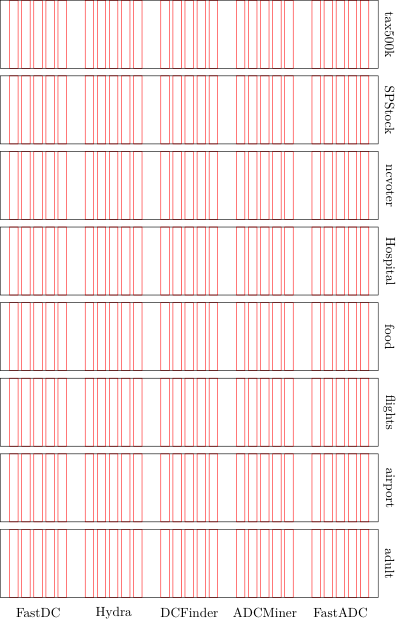

In [156]:
pic = tikz.Picture()
image(pic)
pic.demo()